In [ ]:
import sys
sys.path.append("../..")

from pathlib import Path

import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from sklearn.utils import resample

from src.config.path import SEGMENTATION_YOLO_PATH

In [70]:
def load_yolo_annotations(label_path, image_shape):

    h, w = image_shape[:2]
    polygons = []

    label_path = Path(label_path)
    if not label_path.exists():
        return []

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) > 5:
                coords = np.array(list(map(float, parts[1:])), dtype=np.float32)
                coords = coords.reshape(-1, 2)

                coords[:, 0] *= w
                coords[:, 1] *= h

                polygons.append(coords)
                
    return polygons

In [ ]:
def polygons_to_mask(polygons, shape):
    mask = np.zeros(shape[:2], dtype=np.uint8)
    
    for polygon in polygons:
        cv2.fillPoly(mask, [np.int32(polygon)], 1)
    
    return mask

In [72]:
def compute_iou(mask_pred, mask_gt):
    intersection = np.logical_and(mask_pred, mask_gt)
    union = np.logical_or(mask_pred, mask_gt)
    
    return intersection.sum() / (union.sum() + 1e-6)

In [73]:
def bootstrap_ci(values, n_bootstrap=1000, ci=0.95):
    bootstrapped_means = []
    
    for _ in range(n_bootstrap):
        sample = resample(values)
        bootstrapped_means.append(np.mean(sample))
    
    lower = np.percentile(bootstrapped_means, (1 - ci) / 2 * 100)
    upper = np.percentile(bootstrapped_means, (1 + ci) / 2 * 100)
    
    return np.mean(values), (lower, upper)

In [74]:
model = YOLO(SEGMENTATION_YOLO_PATH)

dataset_path = "../../datasets/merged/test"

images_dir = Path(dataset_path) / "images"
labels_dir = Path(dataset_path) / "labels"

images = list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png"))
labels = list(labels_dir.glob("*.txt"))

In [ ]:
values = []

for image_path, label_path in tqdm(zip(images, labels), total=len(images)):

    image_path = str(image_path)
    label_path = str(label_path)

    results = model.predict(image_path, classes=[0], verbose=False)

    if results[0].masks is None or results[0].masks.xy is None:
        continue

    shape = results[0].orig_shape

    gt_polygons = load_yolo_annotations(label_path, shape)
    pred_polygons = results[0].masks.xy

    mask_gt = polygons_to_mask(gt_polygons, shape)
    mask_pred = polygons_to_mask(pred_polygons, shape)

    iou = compute_iou(mask_pred, mask_gt)
    values.append(iou)

mean_iou, (low_iou, high_iou) = bootstrap_ci(values)

print(f"IoU [95% CI]: {mean_iou:.4f} [{low_iou:.4f}, {high_iou:.4f}]")

  1%|          | 29/4000 [01:30<3:31:42,  3.20s/it]

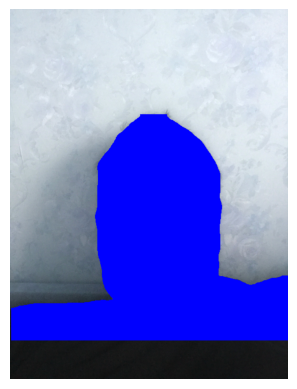

In [ ]:
import matplotlib.pyplot as plt

image = results[0].orig_img

image[mask_pred == 1] = (0, 0, 255)

plt.imshow(image)
plt.axis('off')
plt.show()